In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image
import time

import torch
from torch import manual_seed as torch_manual_seed
import random
import numpy as np

from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn

def setup_seed(seed):
    torch_manual_seed(seed)
    manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True

SEED = 42
setup_seed(SEED)

In [4]:
# Extract contenty
!unzip -q "/content/drive/My Drive/Colab Notebooks/dataset.zip"

In [5]:
from sklearn.datasets import load_files

data_dir_train = "train/"
data_dir_test = "test/"
batch_size = 32;

In [5]:
from torch.utils.data import DataLoader, random_split
from torch import Generator
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder

from torchvision import transforms
data_transforms = transforms.Compose(
    [   transforms.Resize((236, 236)),
        #transforms.RandomHorizontalFlip(p=0.5), # Applying Augmentation
        #transforms.RandomVerticalFlip(p=0.5),
        #transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )
    ]
)

TEST_RATIO = 0.2
BATCH_SIZE = 32

# Download and load the training data
size_all = 120000
print(f'Before splitting the full dataset into train and test: len(dataset_all)={size_all}')


size_test = 20000
size_train = 100000

dataset_train = ImageFolder(
    data_dir_train,
    transform=data_transforms,
)
dataset_test = ImageFolder(
    data_dir_test,
    transform=data_transforms,
)
print(f'After splitting the full dataset into train and test: len(dataset_train)={len(dataset_train)}. len(dataset_test)={len(dataset_test)}')

from sklearn.model_selection import train_test_split
size_val = int(len(dataset_train) * TEST_RATIO)
size_train_train = len(dataset_train) - size_val
training, val = random_split(dataset_train, [size_train_train, size_val], generator=Generator().manual_seed(SEED))

print(f'After splitting the training dataset into train and validation: len(training)={len(training)}. len(val)={len(val)}')

Before splitting the full dataset into train and test: len(dataset_all)=120000
After splitting the full dataset into train and test: len(dataset_train)=100000. len(dataset_test)=20000
After splitting the training dataset into train and validation: len(training)=80000. len(val)=20000


In [6]:
from torch.optim.lr_scheduler import StepLR

def train_loop(dataloader, model, loss_fn, optimizer, calculate_accuracy = True):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    # Initiate lists to hold epoch results
    losses_train = []
    steps = []
    if calculate_accuracy:
        accuracies_epoch = []
    for batch, (X, y) in enumerate(dataloader):
        # Move data from CPU to GPU
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        # Compute prediction and loss
        pred = model(X)
        y =y.to(torch.int64)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        if batch % 1000 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        if type(loss) != float:
            losses_train.append(loss.float())
        else:
            losses_train.append(loss)

        steps.append(current)

        if calculate_accuracy:
            with torch.no_grad():
                accuracy_batch = (pred.argmax(1) == y).type(torch.float).sum().item()/len(y)
            accuracies_epoch.append(accuracy_batch)
    if not calculate_accuracy:
        return losses_train, [], steps
    return losses_train, accuracies_epoch, steps

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            pred = model(X)
            y=y.to(torch.int64)

            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

def train(model, num_epochs, loss_function, optimizer, dataloader_train, dataloader_valid, calculate_accuracy=True):
    losses_train_all_epochs = []
    accuracies_train_all_epochs = []
    steps_all_epochs = []
    accuracies_val_all_epochs = []
    losses_val_all_epochs = []
    scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

    # Early stopping parameters
    # best_val_loss = float('inf')
    # patience = 5
    # patience_counter = 0

    for t in range(num_epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        losses_train, accuracies_epoch, steps = train_loop(dataloader_train, model, loss_function, optimizer, calculate_accuracy=calculate_accuracy)
        losses_train_all_epochs.append(losses_train)
        accuracies_train_all_epochs.append(accuracies_epoch)
        steps_all_epochs.append(steps)

        accuracy_val, loss_val = test_loop(dataloader_valid, model, loss_function)
        accuracies_val_all_epochs.append(accuracy_val)
        losses_val_all_epochs.append(loss_val)
        scheduler.step()

        # Early stopping
        # if loss_val < best_val_loss:
            # best_val_loss = loss_val
            # patience_counter = 0
        # else:
            # patience_counter += 1
            # if patience_counter >= patience:
                # print("Early stopping")
                # break
    print("Done!")
    return accuracies_train_all_epochs, accuracies_val_all_epochs, losses_train_all_epochs, losses_val_all_epochs

In [7]:
def find_classes(data_dir):
    classes = os.listdir(data_dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


classes, class_to_idx = find_classes(data_dir_train)
print(classes)
class_names = classes

['FAKE', 'REAL']


In [8]:
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val, batch_size=batch_size, shuffle=False)
train_dataloader = DataLoader(training, batch_size=batch_size, shuffle=True)

dataloaders = {'train':train_dataloader, 'val': val_dataloader, 'test':test_dataloader}
dataset_sizes = {'train':len(dataset_train), 'val': len(val_dataloader), 'test':len(dataset_test)}

In [9]:
from torchvision.models import efficientnet_v2_l

class EffNet(nn.Module):
    def __init__(self, num_classes):
        super(EffNet, self).__init__()
        self.effnet = efficientnet_v2_l(weights='DEFAULT')

        for param in self.effnet.parameters():
            param.requires_grad = False

        # for param in self.effnet.features[-2:].parameters():
            # param.requires_grad = True

        self.effnet.classifier[1] = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.effnet(x)
        return x

In [10]:
num_classes = 2

model = EffNet(num_classes).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10
start_time = time.time()
accuracies_train_all_epochs, accuracies_val_all_epochs, losses_train_all_epochs, losses_val_all_epochs = train(model, epochs, loss_fn, optimizer, dataloaders['train'], dataloaders['val'])
end_time = time.time()
print(f"Training time: {end_time - start_time} seconds")

Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:03<00:00, 149MB/s]


Epoch 1
-------------------------------
loss: 0.882218  [   32/80000]
loss: 1.108654  [32032/80000]
loss: 1.139156  [64032/80000]
Test Error: 
 Accuracy: 88.1%, Avg loss: 0.356258 

Epoch 2
-------------------------------
loss: 0.908941  [   32/80000]
loss: 1.316966  [32032/80000]
loss: 0.999284  [64032/80000]
Test Error: 
 Accuracy: 88.1%, Avg loss: 0.381966 

Epoch 3
-------------------------------
loss: 1.076843  [   32/80000]
loss: 0.403760  [32032/80000]
loss: 0.518694  [64032/80000]
Test Error: 
 Accuracy: 87.9%, Avg loss: 0.367205 

Epoch 4
-------------------------------
loss: 0.387172  [   32/80000]
loss: 0.917638  [32032/80000]
loss: 0.632439  [64032/80000]
Test Error: 
 Accuracy: 90.1%, Avg loss: 0.239004 

Epoch 5
-------------------------------
loss: 0.547528  [   32/80000]
loss: 0.224937  [32032/80000]
loss: 0.189452  [64032/80000]
Test Error: 
 Accuracy: 90.0%, Avg loss: 0.246482 

Epoch 6
-------------------------------
loss: 0.359214  [   32/80000]
loss: 0.294170  [320

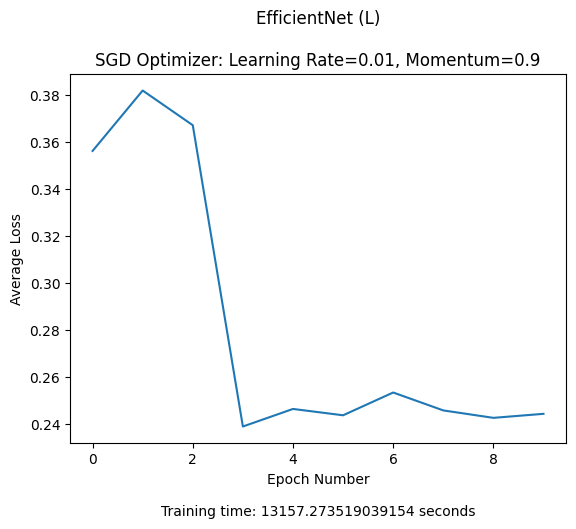

In [11]:
# Sample list of y values
avg_loss = [0.356258, 0.381966, 0.367205, 0.239004, 0.246482, 0.243784, 0.253478, 0.245858, 0.242695, 0.244405]

# Generate corresponding x values (assuming x values are just indices)
epoch = range(len(avg_loss))

# Plot the line
plt.plot(epoch, avg_loss)

# Add labels and title
plt.xlabel(f'Epoch Number\n\nTraining time: {end_time - start_time} seconds')
plt.ylabel('Average Loss')
plt.title('EfficientNet (L)\n\nSGD Optimizer: Learning Rate=0.01, Momentum=0.9')

# Display the plot
plt.show()

In [11]:
num_classes = 2

model = EffNet(num_classes).to(device)

loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10
start_time = time.time()
accuracies_train_all_epochs, accuracies_val_all_epochs, losses_train_all_epochs, losses_val_all_epochs = train(model, epochs, loss_fn, optimizer, dataloaders['train'], dataloaders['val'])
end_time = time.time()
print(f"Training time: {end_time - start_time} seconds")

Epoch 1
-------------------------------
loss: 0.756018  [   32/80000]
loss: 0.352516  [32032/80000]
loss: 0.480563  [64032/80000]
Test Error: 
 Accuracy: 88.7%, Avg loss: 0.268964 

Epoch 2
-------------------------------
loss: 0.151739  [   32/80000]
loss: 0.396627  [32032/80000]
loss: 0.348255  [64032/80000]
Test Error: 
 Accuracy: 89.8%, Avg loss: 0.245589 

Epoch 3
-------------------------------
loss: 0.177829  [   32/80000]
loss: 0.329612  [32032/80000]
loss: 0.373456  [64032/80000]
Test Error: 
 Accuracy: 88.8%, Avg loss: 0.268542 

Epoch 4
-------------------------------
loss: 0.289585  [   32/80000]
loss: 0.559779  [32032/80000]
loss: 0.381054  [64032/80000]
Test Error: 
 Accuracy: 90.2%, Avg loss: 0.245931 

Epoch 5
-------------------------------
loss: 0.218857  [   32/80000]
loss: 0.270560  [32032/80000]
loss: 0.589278  [64032/80000]
Test Error: 
 Accuracy: 90.0%, Avg loss: 0.249301 

Epoch 6
-------------------------------
loss: 0.321225  [   32/80000]
loss: 0.416850  [320

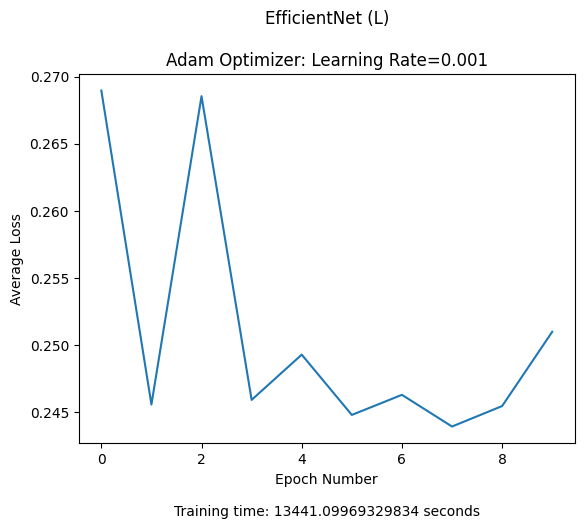

In [12]:
# Sample list of y values
avg_loss = [0.268964, 0.245589, 0.268542, 0.245931, 0.249301, 0.244812, 0.246308, 0.243949, 0.245474, 0.251004]

# Generate corresponding x values (assuming x values are just indices)
epoch = range(len(avg_loss))

# Plot the line
plt.plot(epoch, avg_loss)

# Add labels and title
plt.xlabel(f'Epoch Number\n\nTraining time: {end_time - start_time} seconds')
plt.ylabel('Average Loss')
plt.title('EfficientNet (L)\n\nAdam Optimizer: Learning Rate=0.001')

# Display the plot
plt.show()

In [13]:
num_classes = 2

model = EffNet(num_classes).to(device)

loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10
start_time = time.time()
accuracies_train_all_epochs, accuracies_val_all_epochs, losses_train_all_epochs, losses_val_all_epochs = train(model, epochs, loss_fn, optimizer, dataloaders['train'], dataloaders['val'])
end_time = time.time()
print(f"Training time: {end_time - start_time} seconds")

Epoch 1
-------------------------------
loss: 0.766178  [   32/80000]
loss: 0.320476  [32032/80000]
loss: 0.496357  [64032/80000]
Test Error: 
 Accuracy: 89.3%, Avg loss: 0.257303 

Epoch 2
-------------------------------
loss: 0.457422  [   32/80000]
loss: 0.181373  [32032/80000]
loss: 0.465910  [64032/80000]
Test Error: 
 Accuracy: 87.0%, Avg loss: 0.299259 

Epoch 3
-------------------------------
loss: 0.391727  [   32/80000]
loss: 0.522375  [32032/80000]
loss: 0.455275  [64032/80000]
Test Error: 
 Accuracy: 88.2%, Avg loss: 0.280419 

Epoch 4
-------------------------------
loss: 0.377678  [   32/80000]
loss: 0.304991  [32032/80000]
loss: 0.613896  [64032/80000]
Test Error: 
 Accuracy: 90.0%, Avg loss: 0.248281 

Epoch 5
-------------------------------
loss: 0.446172  [   32/80000]
loss: 0.217550  [32032/80000]
loss: 0.250099  [64032/80000]
Test Error: 
 Accuracy: 90.2%, Avg loss: 0.247178 

Epoch 6
-------------------------------
loss: 0.240350  [   32/80000]
loss: 0.140568  [320

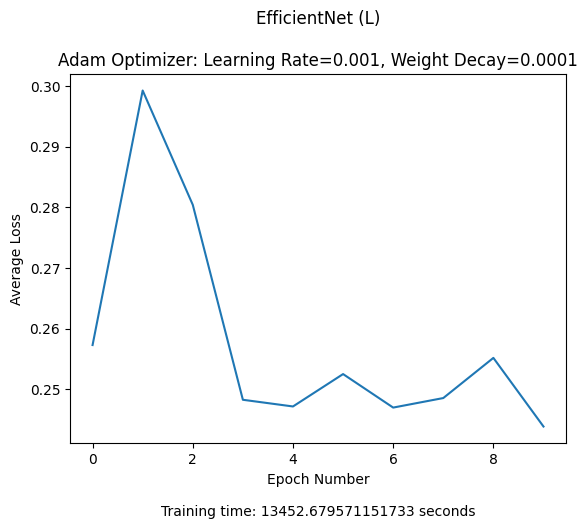

In [7]:
# Sample list of y values
avg_loss = [0.257303, 0.299259, 0.280419, 0.248281, 0.247178, 0.252518, 0.246994, 0.248565, 0.255186, 0.243872]

# Generate corresponding x values (assuming x values are just indices)
epoch = range(len(avg_loss))

# Plot the line
plt.plot(epoch, avg_loss)

# Add labels and title
plt.xlabel(f'Epoch Number\n\nTraining time: {end_time - start_time} seconds')
plt.ylabel('Average Loss')
plt.title('EfficientNet (L)\n\nAdam Optimizer: Learning Rate=0.001, Weight Decay=0.0001')

# Display the plot
plt.show()